### Denoising AutoEncoder

Importamos las librerías necesarias.

In [6]:
import wandb
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import os
import matplotlib.pyplot as plt
import glob

print(tf.__version__)

2.18.0


In [3]:
wandb.login()

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: pablo-blanco (arturo-torres-iteso) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

Vamos a cargar las imágenes ya preprocesadas que están almacenadas como .npy.

In [4]:
train_data_path = "/content/Deep_learning/Proyecto 1 - DAE + VAE/processed_dataset/train/*/*.npy"
val_data_path   = "/content/Deep_learning/Proyecto 1 - DAE + VAE/processed_dataset/val/*/*.npy"
test_data_path  = "/content/Deep_learning/Proyecto 1 - DAE + VAE/processed_dataset/test/*/*.npy"

In [5]:
def load_image(file_path):
    """
    Carga el archivo .npy desde la ruta dada y lo retorna como un np.array de tipo float32.
    """
    # file_path es un tensor tipo tf.string, convertimos a str en Python
    file_path = file_path.numpy().decode("utf-8")
    image = np.load(file_path).astype(np.float32)  # shape (256,256,3) según tu preprocesado
    return image

In [6]:
def load_and_preprocess(file_path):
    """
    Carga la imagen .npy, la deja en [0,1] (ya normalizada),
    y agrega ruido gaussiano. Devuelve (noisy_image, clean_image).
    """
    # tf.py_function permite usar funciones de NumPy dentro de un pipeline de tf.data
    image = tf.py_function(func=load_image, inp=[file_path], Tout=tf.float32)
    image.set_shape([256, 256, 3])  # Ajusta si tu imagen tiene otro tamaño

    clean_image = image  # La imagen limpia (original)

    # Agregar ruido gaussiano
    noise_std = 0.3  # Desviación estándar del ruido
    noise = tf.random.normal(shape=tf.shape(image), mean=0.0, stddev=noise_std, dtype=tf.float32)
    noisy_image = tf.clip_by_value(image + noise, 0.0, 1.0)

    return noisy_image, clean_image

In [7]:
train_file_paths = glob.glob(train_data_path, recursive=True)
val_file_paths   = glob.glob(val_data_path,   recursive=True)
test_file_paths  = glob.glob(test_data_path,  recursive=True)

print("Total imágenes (train):", len(train_file_paths))
print("Total imágenes (val):",   len(val_file_paths))
print("Total imágenes (test):",  len(test_file_paths))


Total imágenes (train): 90
Total imágenes (val): 20
Total imágenes (test): 20


In [8]:
# Convertir las rutas en tf.data.Dataset
train_dataset = tf.data.Dataset.from_tensor_slices(train_file_paths)
val_dataset   = tf.data.Dataset.from_tensor_slices(val_file_paths)
test_dataset  = tf.data.Dataset.from_tensor_slices(test_file_paths)

In [9]:
# Mapear la función de carga y preprocesado (aplica ruido a cada imagen)
train_dataset = train_dataset.map(load_and_preprocess, num_parallel_calls=tf.data.AUTOTUNE)
val_dataset   = val_dataset.map(load_and_preprocess,   num_parallel_calls=tf.data.AUTOTUNE)
test_dataset  = test_dataset.map(load_and_preprocess,  num_parallel_calls=tf.data.AUTOTUNE)


In [10]:
# Definir batch y prefetch
batch_size = 16
train_dataset = train_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
val_dataset   = val_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
test_dataset  = test_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)


Shape de noisy_batch: (16, 256, 256, 3)
Shape de clean_batch: (16, 256, 256, 3)


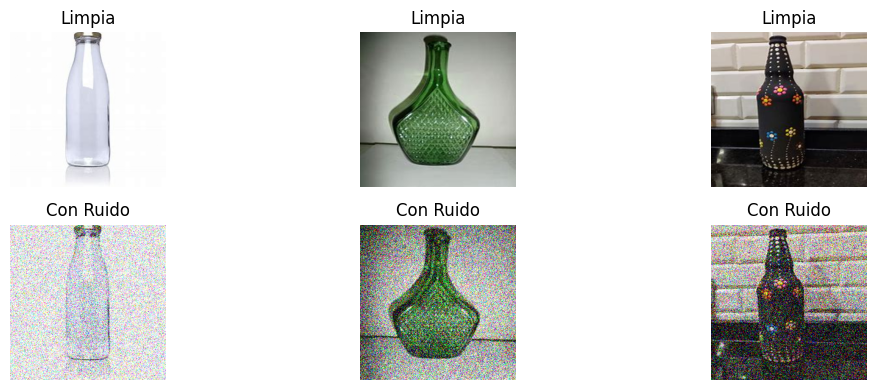

In [11]:
noisy_batch, clean_batch = next(iter(train_dataset))

print("Shape de noisy_batch:", noisy_batch.shape)
print("Shape de clean_batch:", clean_batch.shape)

# Mostrar 3 ejemplos
plt.figure(figsize=(12, 4))
for i in range(3):
    plt.subplot(2, 3, i+1)
    plt.imshow(clean_batch[i].numpy())
    plt.title("Limpia")
    plt.axis("off")

    plt.subplot(2, 3, i+4)
    plt.imshow(noisy_batch[i].numpy())
    plt.title("Con Ruido")
    plt.axis("off")

plt.tight_layout()
plt.show()

Aquí ya le agregamos ruído a nuestras imágenes, que están listas para meterse a nuestro modelo.

In [12]:
def create_dae_model(input_shape=(256,256,3)):
    """
    Crea y devuelve un modelo Keras para Denoising Autoencoder (DAE).

    Parámetros:
    - input_shape: tupla con (altura, ancho, canales).

    Retorna:
    - model: objeto keras.Model listo para compilar.
    """
    # ENCODER
    inputs = keras.Input(shape=input_shape, name="input_image")

    # Capa Conv 1
    x = layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding='same')(inputs)
    x = layers.MaxPooling2D((2,2), padding='same')(x)  # reduce a la mitad altura y ancho

    # Capa Conv 2
    x = layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2,2), padding='same')(x)

    # Capa Conv 3 (Latent Space)
    x = layers.Conv2D(filters=128, kernel_size=(3,3), activation='relu', padding='same')(x)
    # En este punto x es la representación "latente" comprimida

    # DECODER
    x = layers.UpSampling2D((2,2))(x)  # aumenta tamaño de la imagen
    x = layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same')(x)

    x = layers.UpSampling2D((2,2))(x)
    x = layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding='same')(x)

    # Capa de salida
    outputs = layers.Conv2D(filters=3, kernel_size=(3,3), activation='sigmoid', padding='same', name="output_image")(x)

    # Construimos el modelo
    model = keras.Model(inputs, outputs, name="DenoisingAutoencoder")
    return model


In [13]:
# Creamos el modelo
model = create_dae_model(input_shape=(256,256,3))

In [14]:
# Compilamos con optimizador Adam y pérdida MSE (para reconstrucción de imagen)
model.compile(optimizer='adam', loss='mse')

# Mostramos la arquitectura
model.summary()


Model: "DenoisingAutoencoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_image (InputLayer)             │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 256, 256, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 128, 128, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 128, 128, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 64, 64, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d (UpSampling2D)         │ (None, 128, 128, 128)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 128, 128, 64)        │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_1 (UpSampling2D)       │ (None, 256, 256, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 256, 256, 32)        │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output_image (Conv2D)                │ (None, 256, 256, 3)         │             867 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 186,371 (728.01 KB)

 Trainable params: 186,371 (728.01 KB)

 Non-trainable params: 0 (0.00 B)

In [15]:
# Define your training loop and integrate wandb logging
def train_model(model, train_dataset, val_dataset, epochs):
  with wandb.init(project="VAE + DAE", entity="arturo-torres-iteso",name="DAE_train6", config={"epochs": epochs, "batch_size": batch_size}):
    config = wandb.config
    for epoch in range(config.epochs):
      for batch_idx, (noisy_batch, clean_batch) in enumerate(train_dataset):
        loss = model.train_on_batch(noisy_batch, clean_batch)
        # Log training loss to wandb
        wandb.log({"train_loss": loss, "epoch": epoch, "batch": batch_idx})

      # Evaluate on validation dataset
      val_loss = model.evaluate(val_dataset, verbose=0)
      # Log validation loss to wandb
      wandb.log({"val_loss": val_loss, "epoch": epoch})

      print(f"Epoch {epoch+1}/{config.epochs}, Loss: {loss:.4f}, Val Loss: {val_loss:.4f}")


# Call the training function
train_model(model, train_dataset, val_dataset, epochs=200)


Epoch 1/200, Loss: 0.1315, Val Loss: 0.0555
Epoch 2/200, Loss: 0.0603, Val Loss: 0.0335
Epoch 3/200, Loss: 0.0364, Val Loss: 0.0328
Epoch 4/200, Loss: 0.0278, Val Loss: 0.0191
Epoch 5/200, Loss: 0.0238, Val Loss: 0.0254
Epoch 6/200, Loss: 0.0222, Val Loss: 0.0169
Epoch 7/200, Loss: 0.0165, Val Loss: 0.0152
Epoch 8/200, Loss: 0.0142, Val Loss: 0.0162
Epoch 9/200, Loss: 0.0136, Val Loss: 0.0148
Epoch 10/200, Loss: 0.0126, Val Loss: 0.0136
Epoch 11/200, Loss: 0.0115, Val Loss: 0.0130
Epoch 12/200, Loss: 0.0112, Val Loss: 0.0130
Epoch 13/200, Loss: 0.0110, Val Loss: 0.0130
Epoch 14/200, Loss: 0.0109, Val Loss: 0.0128
Epoch 15/200, Loss: 0.0104, Val Loss: 0.0123
Epoch 16/200, Loss: 0.0099, Val Loss: 0.0108
Epoch 17/200, Loss: 0.0091, Val Loss: 0.0101
Epoch 18/200, Loss: 0.0087, Val Loss: 0.0095
Epoch 19/200, Loss: 0.0087, Val Loss: 0.0093
Epoch 20/200, Loss: 0.0090, Val Loss: 0.0097
Epoch 21/200, Loss: 0.0092, Val Loss: 0.0113
Epoch 22/200, Loss: 0.0095, Val Loss: 0.0109
Epoch 23/200, Loss:

batch,▅▁▂▁▅▁▇▁▇▅▇█▁▂▂█▇▂▇▁▅▂▁▂▅▂▅▂▅▂▂▄▁▁▂▄▅█▅▄
epoch,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▅▅▆▆▆▆▆▆▆▆▆▇▇▇▇██████
train_loss,█▅▃▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,██▄▄▅▃▃▃▃▃▂▂▂▂▂▂▁▁▁▁▂▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁
batch,5
epoch,199
train_loss,0.00287
val_loss,0.00323


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 465ms/step


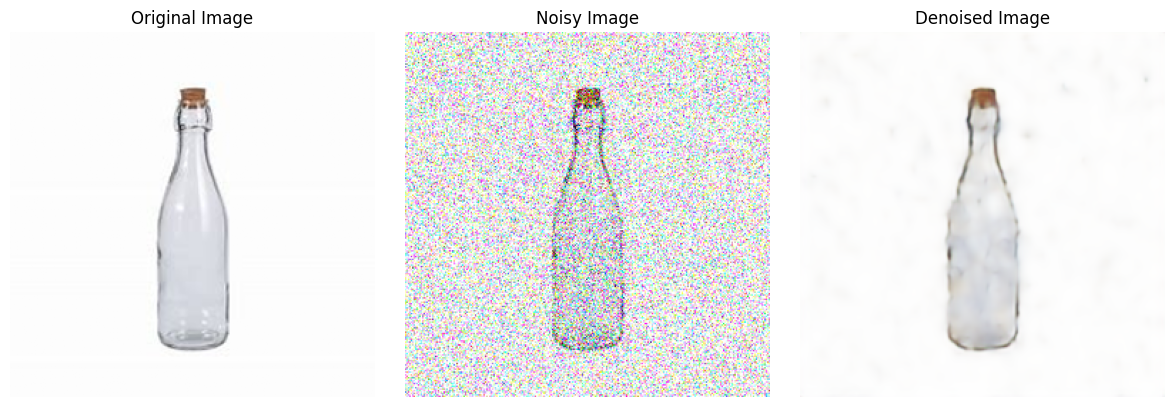

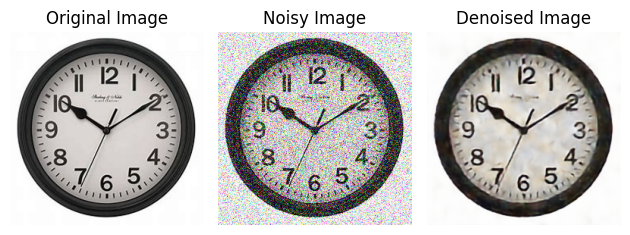

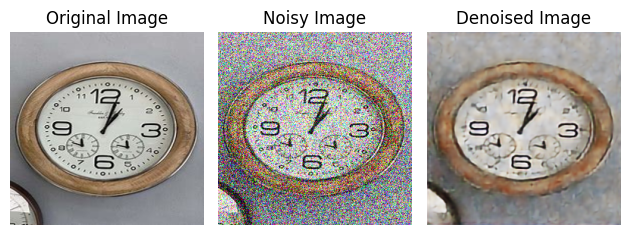

In [16]:
# Obtener un batch de imágenes de prueba
noisy_batch, clean_batch = next(iter(test_dataset))

# Predecir las imágenes denoised usando el modelo entrenado
denoised_batch = model.predict(noisy_batch)

# Mostrar las imágenes originales, ruidosas y denoised
plt.figure(figsize=(12, 4))
for i in range(3):
    plt.subplot(1, 3, 1)
    plt.imshow(clean_batch[-i].numpy())
    plt.title("Original Image")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(noisy_batch[-i].numpy())
    plt.title("Noisy Image")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(denoised_batch[-i])
    plt.title("Denoised Image")
    plt.axis("off")

    plt.tight_layout()
    plt.show()

In [18]:
# Guardar en formato .h5
model.save('./Deep_learning/Proyecto 1 - DAE + VAE/Models/dae2.h5')

# Subir a W&B
artifact = wandb.Artifact('dae2', type='model')
artifact.add_file('./Deep_learning/Proyecto 1 - DAE + VAE/Models/dae2.h5')

with wandb.init(project="VAE_DAE_Project", entity="arturo-torres-iteso"):
    wandb.log_artifact(artifact)
    print("Modelo subido exitosamente a WandB!")


Modelo subido exitosamente a WandB!


In [20]:
%cd Deep_learning

/content/Deep_learning


In [21]:
!git config --global user.email "cartosan2007@gmail.com"
!git config --global user.name "arturotowers"

In [22]:
! git add.
! gut commit -m "Subimos los modelos"

git: 'add.' is not a git command. See 'git --help'.

The most similar command is
	add
/bin/bash: line 1: gut: command not found


In [23]:
! git commit -m "Subimos los modelos"

[ArturoTorres f784350] Subimos los modelos
 1 file changed, 0 insertions(+), 0 deletions(-)
 create mode 100644 Proyecto 1 - DAE + VAE/Models/dae2.h5


Enumerating objects: 7, done.
Counting objects: 100% (7/7), done.
Delta compression using up to 12 threads
Compressing objects: 100% (4/4), done.
Writing objects: 100% (5/5), 1.96 MiB | 2.93 MiB/s, done.
Total 5 (delta 2), reused 0 (delta 0), pack-reused 0
remote: Resolving deltas: 100% (2/2), completed with 2 local objects.
To https://github.com/arturotowers/Deep_learning.git
   eea8ebf..f784350  ArturoTorres -> ArturoTorres


In [2]:
import tensorflow as tf
from tensorflow import keras

In [8]:
dae = tf.keras.models.load_model(
    "/content/Deep_learning/Proyecto 1 - DAE + VAE/Models/dae2.h5",
    custom_objects={'mse': tf.keras.losses.MeanSquaredError()})

In [9]:
# Recompilar para asegurar compatibilidad
dae.compile(
    optimizer='adam',
    loss=tf.keras.losses.MeanSquaredError()  # Usar la clase aquí también
)

In [10]:
dae.save("/content/Deep_learning/Proyecto 1 - DAE + VAE/Models/dae_model.keras", save_format="keras_v3")

In [11]:
import os

model_path = "/content/Deep_learning/Proyecto 1 - DAE + VAE/Models/dae_model.keras"

# Verificar que el archivo existe y tiene tamaño adecuado
if os.path.exists(model_path):
    print(f"✅ Modelo guardado correctamente en: {model_path}")
    print("Tamaño del archivo:", os.path.getsize(model_path), "bytes")
else:
    print("❌ Error: El modelo no se guardó correctamente")

✅ Modelo guardado correctamente en: /content/Deep_learning/Proyecto 1 - DAE + VAE/Models/dae_model.keras
Tamaño del archivo: 791534 bytes


In [12]:
# Cargar el nuevo modelo
loaded_model = tf.keras.models.load_model("/content/Deep_learning/Proyecto 1 - DAE + VAE/Models/dae_model.keras")

# Probar inferencia (sin warnings)
test_image = np.random.rand(1, 256, 256, 3).astype(np.float32)
pred = loaded_model.predict(test_image)
print("¡Funciona correctamente!", pred.shape)

/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 26 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
¡Funciona correctamente! (1, 256, 256, 3)


In [13]:
!pip install huggingface_hub

In [16]:
from huggingface_hub import notebook_login

notebook_login()

In [17]:
from huggingface_hub import HfApi

api = HfApi()

# Ruta local del modelo
model_path = "/content/Deep_learning/Proyecto 1 - DAE + VAE/Models/dae_model.keras"

# Subir a la ruta deseada en tu repositorio
api.upload_file(
    path_or_fileobj=model_path,
    repo_id="Ju4nPa2009/VAE_DAE",
    path_in_repo="models/dae_model.keras",  # Ruta dentro del repositorio
    repo_type="model"
)

print("✅ Modelo subido exitosamente!")

dae_model.keras:   0%|          | 0.00/792k [00:00<?, ?B/s]

✅ Modelo subido exitosamente!


In [24]:
!git add Proyecto\ 1\ -\ DAE\ +\ VAE/Notebooks/DAE.ipynb

In [25]:
!git status

On branch ArturoTorres
Your branch is up to date with 'origin/ArturoTorres'.

nothing to commit, working tree clean
